In [3]:
import numpy
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

In [102]:
def compute_matrix_cost(N_chan,N_pol,N_sky,N_ant,N_time):
    
    mul_cost = 6 * N_chan * N_pol * N_sky * N_ant * N_time
    add_cost = 3 * N_chan * N_pol * N_sky * N_time * (N_pol-1)
    
    total_cost = mul_cost + add_cost
    
    bytes_loaded = 8*(N_chan * N_pol * N_sky * N_ant + N_ant * N_time)
    print(bytes_loaded)
    return total_cost,total_cost/bytes_loaded

def compute_fx_cost(N_chan,N_pol,N_ant,N_time):
    cost = 6 * N_chan * N_pol * N_time *(N_ant**2)
    bytes_loaded = 8*(N_chan * N_pol * N_time * N_ant)
    return cost,cost/bytes_loaded

def compute_epic_fft_cost(N_chan,N_pol,N_ant,N_grid,N_time,N_supp):
    fft_cost = 5 * N_chan * N_pol * N_time * N_grid * numpy.log2(N_grid)
    convolution_cost = 8 * N_supp * N_chan * N_pol * N_time * N_ant # 8 comes from complex multiply + add
    total_cost = fft_cost + convolution_cost
    bytes_loaded = 8 * (N_chan * N_pol * N_time * N_grid) + 8 * (N_chan * N_pol * N_time * N_ant + N_supp)
    
    return total_cost,total_cost/bytes_loaded

In [81]:
N_time = numpy.asarray([512,1024,2048,4096])

ops,op_int = compute_matrix_cost(8,2,4096,256,N_time)


[135266304 136314880 138412032 142606336]


In [40]:
ops

array([ 51640270848, 103280541696, 206561083392, 413122166784])

In [41]:
op_int

array([ 381.76744186,  757.66153846, 1492.36363636, 2896.94117647])

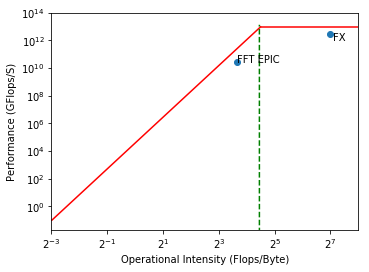

In [42]:
opint = [12.5,128]
flops = [2.662e10,3e12]
txt = ["FFT EPIC","FX"]

f,ax = plt.subplots(1,figsize=(5.5,4.0))
ax.scatter(opint,flops)
#plt.title("Roofline Model of EPIC vs FX")
plt.xlabel("Operational Intensity (Flops/Byte)")
plt.ylabel("Performance (GFlops/S)")

#Roof of roofline

line = Line2D([0.126,22.53],[0.1,9.3e12],c='r')
ax.add_line(line)
line2 = Line2D([22.53,256],[9.3e12,9.3e12],c='r')
ax.add_line(line2)
line3 = Line2D([22.53,21.875],[0,13.1e12],c='g',ls='--')
ax.add_line(line3)

opint_txt = [12.5,135]
flops_txt = [2.662e10,1e12]
for i,txt in enumerate(txt):
    ax.annotate(txt,(opint[i],flops[i]),(opint_txt[i],flops_txt[i]))
#a2.set_xlim([0,128]

plt.yscale('log',basey=10)
plt.xscale('log',basex=2)
plt.xlim([0.125,256])
plt.ylim([0,10e13])
#plt.autoscale(True)
plt.show()


In [125]:
def generate_roofline():
    
    f,ax = plt.subplots(1,figsize=(6.0,7.0))
    
    #Roof of roofline
    line = Line2D([0.126,22.53],[0.1,9.3e12],c='r')
    ax.add_line(line)
    line2 = Line2D([22.53,4096],[9.3e12,9.3e12],c='r')
    ax.add_line(line2)
    line3 = Line2D([22.53,21.875],[0.0001,13.1e12],c='g',ls='--')
    ax.add_line(line3)
    
    #Add FFT EPIC and FX Correlator
    #opint = [12.5,128]
    #flops = [2.662e10,3e12]
    #txt = ["FFT EPIC","FX"]
    #ax.scatter(opint,flops)
    
    #opint_txt = [12.5,135]
    #flops_txt = [2.662e10,1e12]
    #for i,txt in enumerate(txt):
    #    ax.annotate(txt,(opint[i],flops[i]),(opint_txt[i],flops_txt[i]))
        
    # Add DFT EPIC and parameterise by times
    
    times = numpy.asarray([32,64,256,512,1024,2048,4096])
    ops,op_int = compute_matrix_cost(1,1,4096,256,times)
    ax.scatter(op_int,ops,marker='^',label='DFT vs Time')
    
    
     # Add DFT EPIC and parameterise by sky points
    
    sky = numpy.asarray([32,64,256,512,1024,2048,4096])
    ops,op_int = compute_matrix_cost(1,1,sky,256,2048)
    ax.scatter(op_int,ops,marker='.',label='DFT vs Sky Points')
    
    # Add FX Correlator and parameterise by sky points for 8 channels/dual pol
    
    ants = numpy.asarray([32,64,256,512,1024,2048,4096])
    ops,op_int = compute_fx_cost(1,1,ants,2048)
    ax.scatter(op_int,ops,marker='+',label='FX Correlator vs Antennas')
    
    # Add EPIC FFT Correlator and parameterise by grid size
    
    grid_size = numpy.asarray([32,64,128,256,512])
    ops,op_int = compute_epic_fft_cost(1,1,256,grid_size,2048,9)
    ax.scatter(op_int,ops,marker='D',label='EPIC FFT Correlator vs Grid Size')
    
    plt.xlabel("Operational Intensity (Flops/Byte)")
    plt.ylabel("Floating Point Operations")
    plt.yscale('log',basey=10)
    plt.xscale('log',basex=2)
    plt.xlim([0.125,4096])
    plt.ylim([100000,10e13])
    plt.legend(loc=2)
    #plt.autoscale(True)
    plt.savefig("roofline.pdf")
    plt.show()

[ 8454144  8519680  8912896  9437184 10485760 12582912 16777216]
[ 4259840  4325376  4718592  5242880  6291456  8388608 12582912]


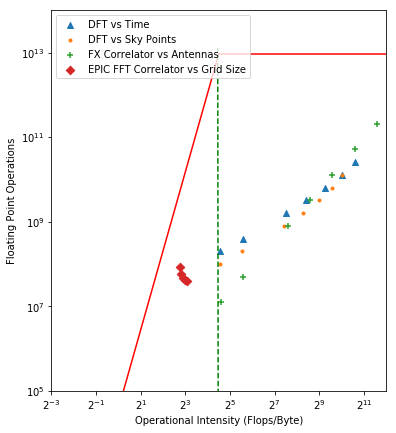

In [126]:
generate_roofline()